### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [ ]:
!pip install biopython
!pip install plotnine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.7 MB/s eta 0:00:00


**1.2 | Import Required Packages**

In [ ]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [ ]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            full_query = f"{query} AND ({year}[Date - Publication])"
            handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
            record = Entrez.read(handle)
            count = int(record["Count"])
            publication_counts[term].append(count)
            handle.close()

    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

search_terms = {
    "ME/CFS Only": "ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome NOT (Cognitive Behavioural Therapy OR CBT OR Graded Exercise Therapy OR GET)",
    "ME/CFS and CBT Only": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome) AND (Cognitive Behavioural Therapy OR CBT) NOT (Graded Exercise Therapy OR GET)",
    "ME/CFS and GET Only": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome) AND (Graded Exercise Therapy OR GET) NOT (Cognitive Behavioural Therapy OR CBT)",
    "ME/CFS and CBT and GET": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome) AND (Cognitive Behavioural Therapy OR CBT) AND (Graded Exercise Therapy OR GET)"
}

start_year = 1980
end_year = 2023  # Assuming current year as end year

publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.head()

,ME/CFS Only,ME/CFS and CBT Only,ME/CFS and GET Only,ME/CFS and CBT and GET
Year,,,,
1980,7,0,0,0
1981,7,0,0,0
1982,5,0,0,0
1983,3,0,0,0
1984,17,0,0,0


In [ ]:
# Check result
publications_df.tail()

,ME/CFS Only,ME/CFS and CBT Only,ME/CFS and GET Only,ME/CFS and CBT and GET
Year,,,,
2019,434,21,5,13
2020,474,24,2,8
2021,620,35,9,9
2022,598,23,3,10
2023,669,25,6,5


In [ ]:
# Convert the data to a long format
long_df = publications_df.reset_index().melt(id_vars='Year', var_name='Category', value_name='Count')

# Calculate the total publications per year for normalization
long_df['Total'] = long_df.groupby('Year')['Count'].transform('sum')

# Calculate the percentage of publications for each category per year
long_df['Percentage'] = 100 * long_df['Count'] / long_df['Total']

# Check result
long_df

,Year,Category,Count,Total,Percentage
0,1980,ME/CFS Only,7,7,100.000000
1,1981,ME/CFS Only,7,7,100.000000
2,1982,ME/CFS Only,5,5,100.000000
3,1983,ME/CFS Only,3,3,100.000000
4,1984,ME/CFS Only,17,17,100.000000
...,...,...,...,...,...
171,2019,ME/CFS and CBT and GET,13,473,2.748414
172,2020,ME/CFS and CBT and GET,8,508,1.574803
173,2021,ME/CFS and CBT and GET,9,673,1.337296
174,2022,ME/CFS and CBT and GET,10,634,1.577287


In [9]:
long_df[long_df["Year"]==2017]

,Year,Category,Count,Total,Percentage
37,2017,ME/CFS Only,362,425,85.176471
81,2017,ME/CFS and CBT Only,32,425,7.529412
125,2017,ME/CFS and GET Only,9,425,2.117647
169,2017,ME/CFS and CBT and GET,22,425,5.176471


### 📈  3 | Visualise Results
---

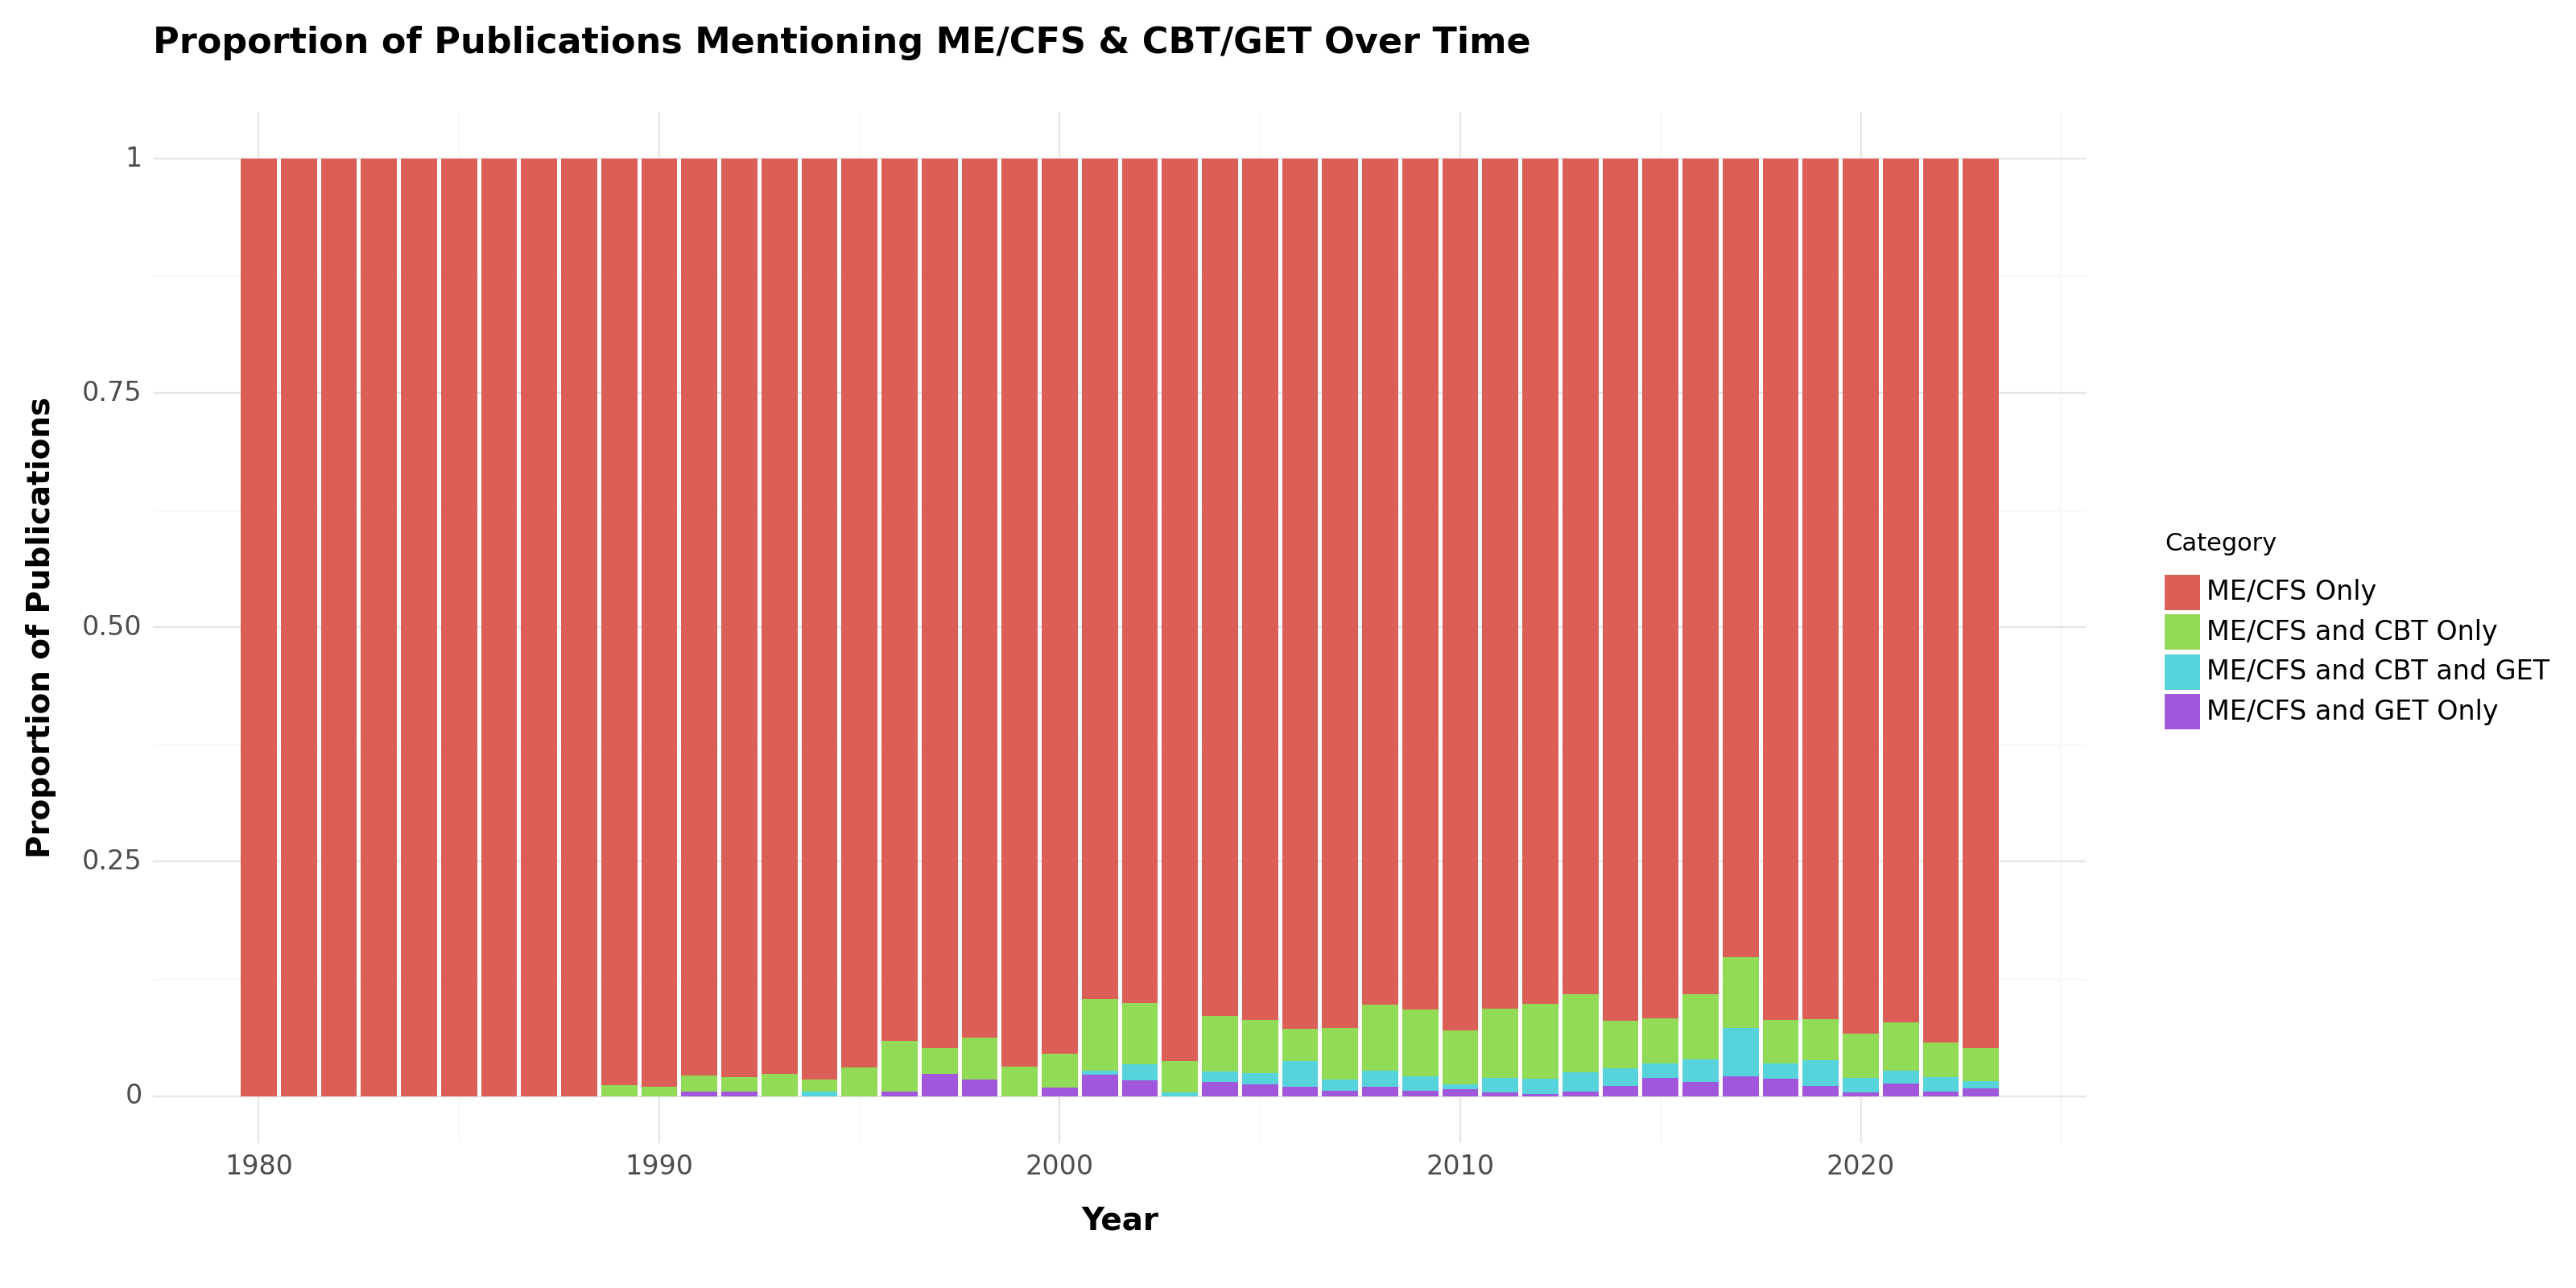

In [ ]:
# Create a percentage stacked bar chart using plotnine
plot = (ggplot(long_df, aes(x='Year', y='Percentage', fill='Category'))
        + geom_bar(stat='identity', position='fill')  # Stacks percentage for each category
        + labs(x='Year', y='Proportion of Publications', fill='Category', title='Proportion of Publications Mentioning ME/CFS & CBT/GET Over Time')
        + theme_minimal()
        + theme(figure_size=(16, 8),
              axis_title=element_text(size=14, weight='bold'),
              axis_text=element_text(size=12),
              plot_title=element_text(size=16, weight='bold'),
              legend_text=element_text(size=12))
        )

# Display the plot
print(plot)